In [2]:
import vis_lc_extraction_class
import glob
import matplotlib.pyplot as plt
import importlib
from astropy.time import Time
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as un
import time
from astropy.io import fits
importlib.reload(vis_lc_extraction_class)


<module 'vis_lc_extraction_new' from '/opt/devel/idavis/scripts/vis_lc_extraction_new.py'>

# New source-finding and position-correcting code
The new code for finding sources is now class-oriented rather than stacking all of the information in dictionaries. The classes are:
* `beam`: describes the beam shape, implemented in the `obs_frame` class for source detection
* `obs_frame`: the class for a single frame. Contains functionality for setting the subframe of sky to look for sources (and setting the new WCS for the subframe), source identification, background statistics
* `radio_source`: The class that holds information about a source detected in an `obs_frame` instance. At a minimum, it contains information on the source labelling and its SkyCoord positions. In the context of the `observation` class, it keeps track of the number of times across the observation it is identified, the average position, and the separation/pos ang between the average position
* `observation`: the class that is responsible for cross-matching sources between sources to build a list of `detected_radio_sources`. It uses information contained for each detected radio source within its instance of `radio_source` to estimate the weighted position change of the source of interest `source` 

## Get files to be used in the example:

In [3]:
fns = glob.glob('/lustre/idavis/2024_04_10_pi1_uma_processing/alldata_v3_briggs0_tukey30/*-image.fits')
fns.sort()
pi_uma = SkyCoord(ra=129.798769*un.deg, dec = 65.020906423*un.deg)

## Using the `obs_frame` class
Here, we also look for sources using the `get_source_positions` function and plot the frame with the sources using `plot_frame`. If you don't want to plot sources, set `plot_sources=False` in the function. If you want plot the full image instead of the cropped frame, set `cropped=False`.

/opt/devel/idavis/scripts/vis_lc_extraction_new.py:234: UserWarning: Working directory not specified, taking it to be /opt/devel/idavis/scripts
  warnings.warn(f"Working directory not specified, taking it to be {self.working_directory}")


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

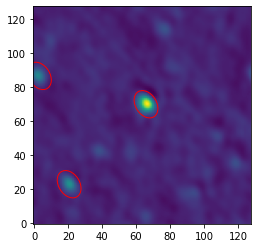

In [4]:
frame = vis_lc_extraction_class.obs_frame(fns[0]) # instantiates a frame class object
frame.cropped_filepath = frame.file_name # setting the cropped filepath the filepath of the original input since the data are already cropped
frame.cropped_wcs = frame.wcs # setting the cropped WCS to the WCS of the original input since the data are already cropped
frame.get_source_positions() # finds positions
frame.plot_frame() # plots the frame and the sources that were detected

## Working with a full observation through the `observation` class
Here, we're instantiating the observation using the `SkyCoord` position of the target of interest (`pi_uma`), the list of file names, and the directory that e.g. cropped files or saved information would be saved to. Because the files in this example are already cropped, I set the `cropped_filepath` and `cropped_wcs` to the file name and WCS of the full-frame properties

In [5]:
obs = vis_lc_extraction_class.observation(pi_uma, fns, '/lustre/idavis/2024_04_10_pi1_uma_processing/')
for f in obs.frames:
    f.cropped_filepath = f.file_name
    f.cropped_wcs = f.wcs

To find sources in all frames, run the `find_sources` function. The `start_reference_list` function makes an initial set of sources to look for in other frames, and `build_observation_source_list` builds the list of sources that are found across the frames. The `detected_sources` list made by the `build_observation_source_list` is in principle the same information as what was found in the `find_associated_sources` in the original code.

In [6]:
print("Finding sources")
t0 = time.time()
obs.find_sources()
print(f"Found sources in {time.time() - t0} seconds")

obs.start_reference_list()

print("Building associated source list")
t0 = time.time()
obs.build_observation_source_list()
print(f"Built list in {time.time() - t0} seconds")

Finding sources
Found sources in 6.947216510772705 seconds
Building associated source list
Built list in 9.812332391738892 seconds


### Get the source fluxes
`get_fluxes_all_frames` returns the flux densities for the sources in the `detected_sources` list and saves them to the `detected_source_fluxes` property as an array of shape n_sources x n_frames. Each radio source object also has its respective flux density saved to the `fluxes` property

In [8]:
obs.get_fluxes_all_frames()

Text(0, 0.5, 'Flux density [Jy]')

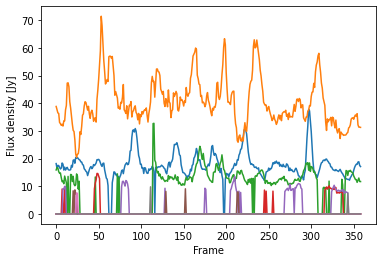

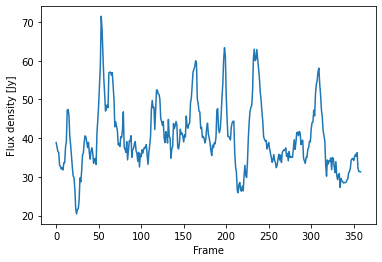

In [14]:
# all fluxes from the observation class property 
plt.plot(obs.detected_source_fluxes)
plt.xlabel("Frame")
plt.ylabel("Flux density [Jy]")

# fluxes from the radio_source class for a single source listed in detected_sources
plt.figure()
plt.plot(obs.detected_sources[1].fluxes)
plt.xlabel("Frame")
plt.ylabel("Flux density [Jy]")

### Get the weighted position changes to estimate the location of the target/source of interest
`calc_space_changes` updates the `seps` and `pos_angs` arrays for each `radio_source` object in the `detected_source` list.
This method also corrects an error in the previous code, which did not account for the degeneracy in the arctan calculation for the position angle. `get_all_star_positions` saves the position of the target of interest to `source_positions` (note that `source` is the target of interest and `detected_sources` are the sources that are actually detected in the frame)

In [12]:
obs.calc_space_changes()
obs.get_all_star_positions()

source_004 not detected in frame 0
source_005 not detected in frame 0
source_006 not detected in frame 0
source_007 not detected in frame 0
source_008 not detected in frame 0


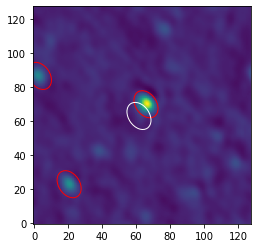

In [41]:
from photutils import EllipticalAperture
frame_idx = 0
frame = obs.frames[frame_idx]
beam = obs.frames[frame_idx].beam
frame.plot_frame(plot_sources=False)

for source in obs.detected_sources:
    try:
        # Convert from SkyCoord to pixel coordinates:
        x, y = obs.frames[frame_idx].cropped_wcs.world_to_pixel(source.positions[frame_idx])
        # Instantiate and plot the aperture:
        ap = EllipticalAperture([(x,y)], beam.bmaj, beam.bmin, (beam.bpa+90)*un.deg.to('rad'))
        ap.plot(color='r')
    except:
        print(f"{source.label} not detected in frame {frame_idx}")

# Get pixel position and plot the source of interest:        
x, y = obs.frames[frame_idx].cropped_wcs.world_to_pixel(obs.source_positions[frame_idx])
ap = EllipticalAperture([(x,y)], beam.bmaj, beam.bmin, (beam.bpa+90)*un.deg.to('rad'))
ap.plot(color='w')
        


### Finally, can get the flux densities from the position of the target of interest
This gets saved to the `source_fluxes` property (again, different from the `detected_source_fluxes`)

In [23]:
obs.get_star_fluxes()

Text(0, 0.5, 'Flux density')

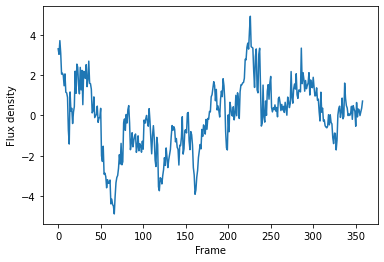

In [24]:
plt.plot(obs.source_fluxes)
plt.xlabel("Frame")
plt.ylabel("Flux density")